In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 1591 files belonging to 15 classes.
Using 1273 files for training.
Found 1591 files belonging to 15 classes.
Using 318 files for validation.
87910968/87910968 [==============================] - 0s 0us/step
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/30
40/40 [==============================] - 21s 414ms/step - loss: 238.7394 - accuracy: 0.1060 - val_loss: 117.4900 - val_accuracy: 0.2296
Epoch 2/30
40/40 [==============================] - 12s 291ms/step - loss: 113.0062 - accuracy: 0.2459 - val_loss: 68.9709 - val_accuracy: 0.3711
Epoch 3/30
40/40 [==============================] - 13s 303ms/step - loss: 64.6146 - accuracy: 0.3802 - val_loss: 39.5891 - val_accuracy: 0.5472
Epoch 4/30
40/40 [==============================] - 13s 280ms/step - loss: 58.7594 - accuracy: 0.4737 - val_loss: 29.6948 - val_accuracy: 0.6101
Epoch 5/30
40/40 [==============================] - 12s 

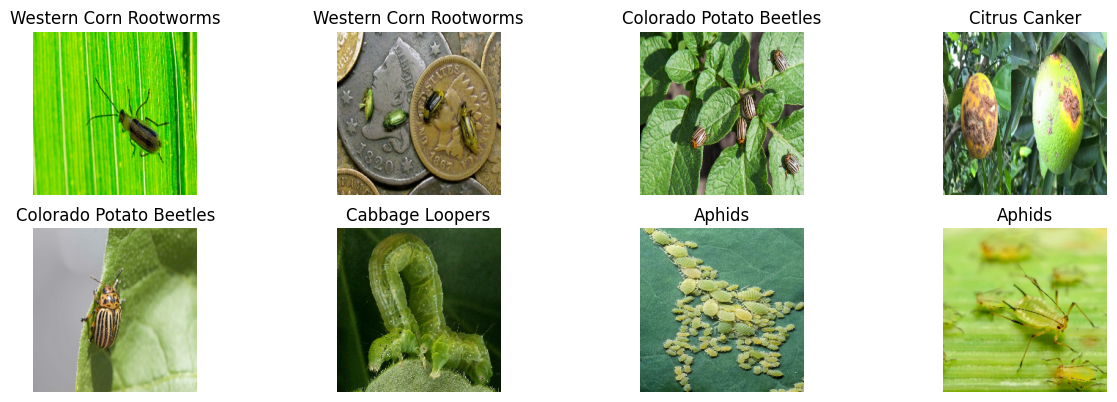

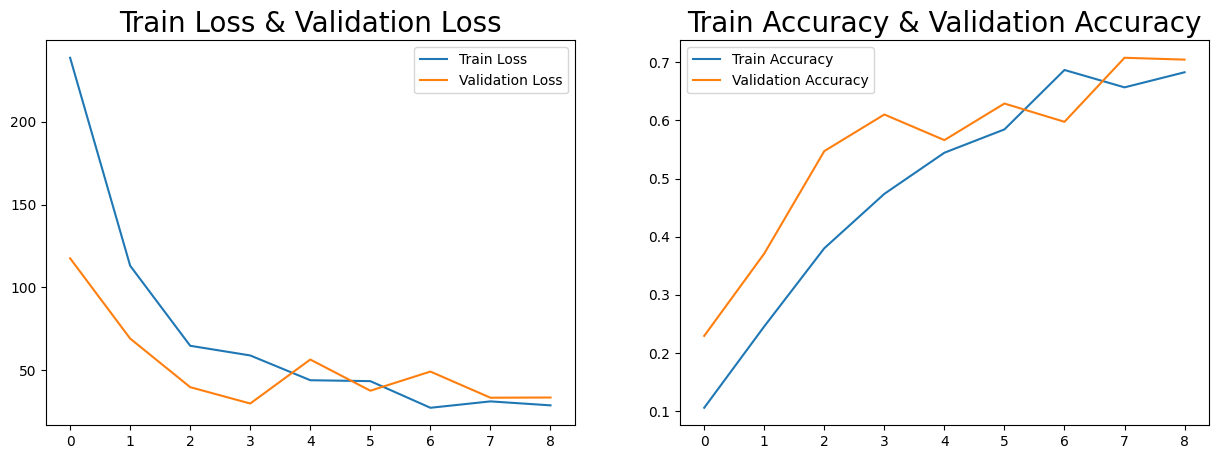

10/10 [==============================] - 4s 214ms/step


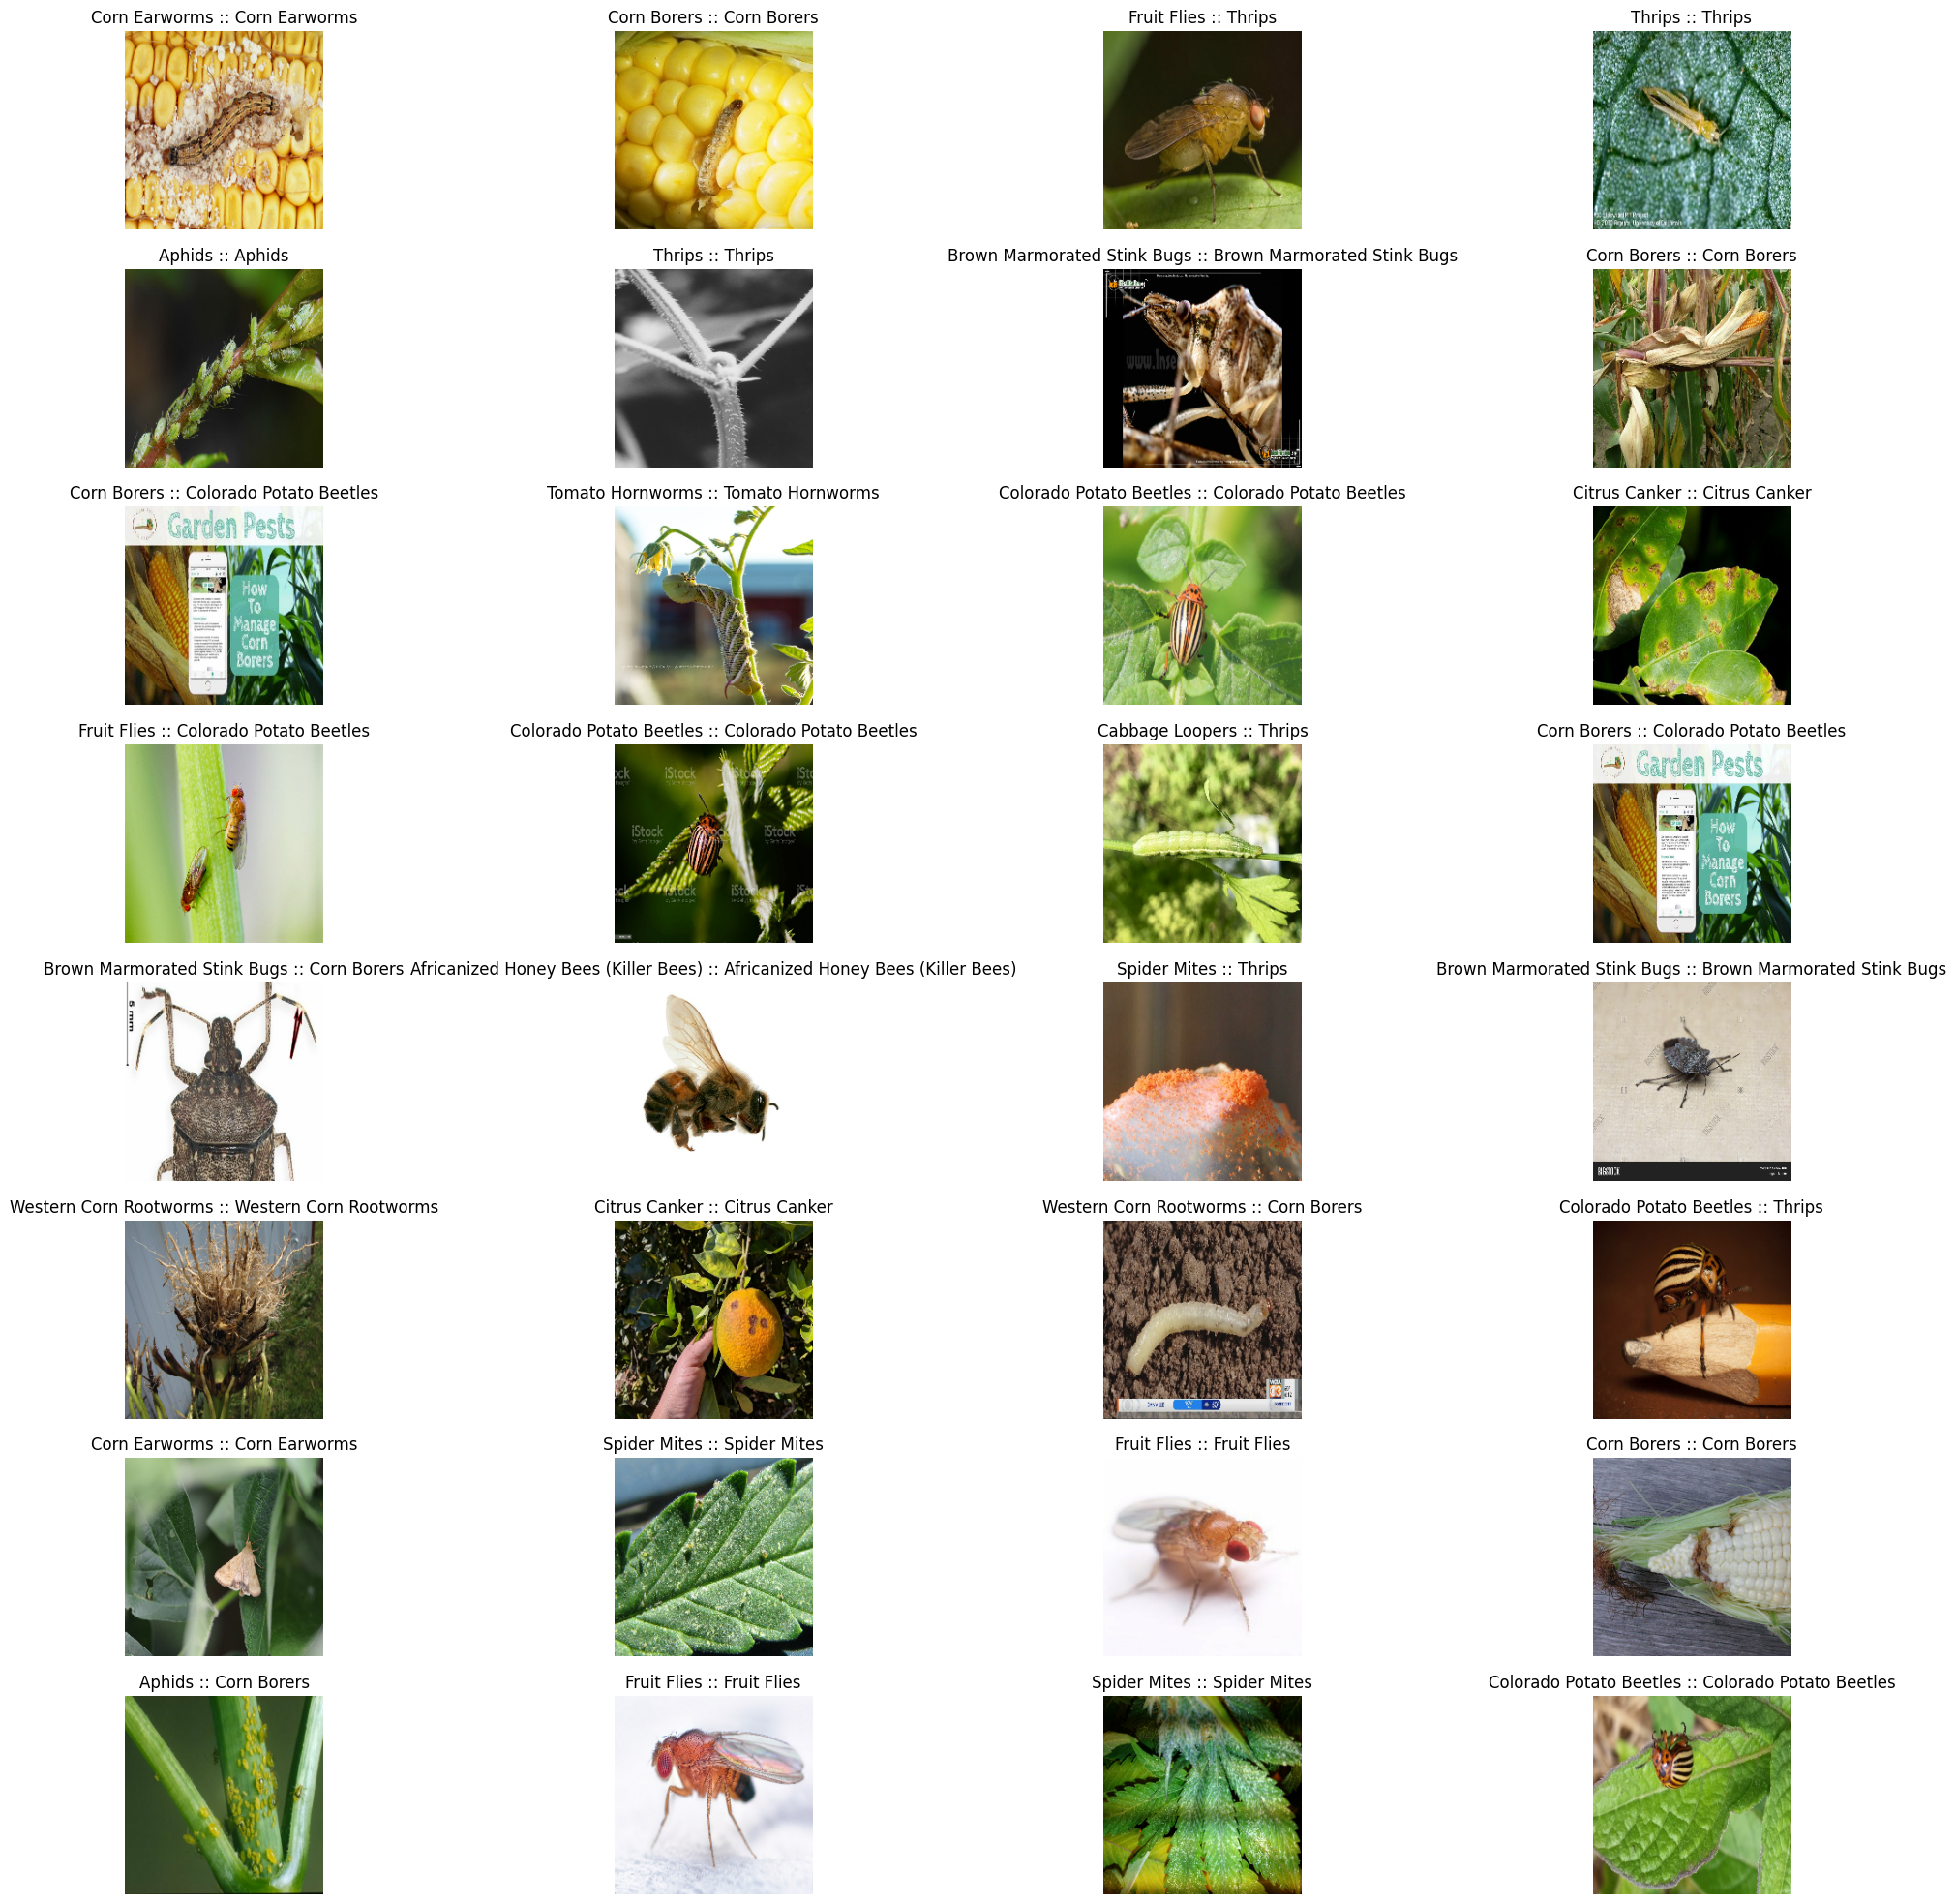

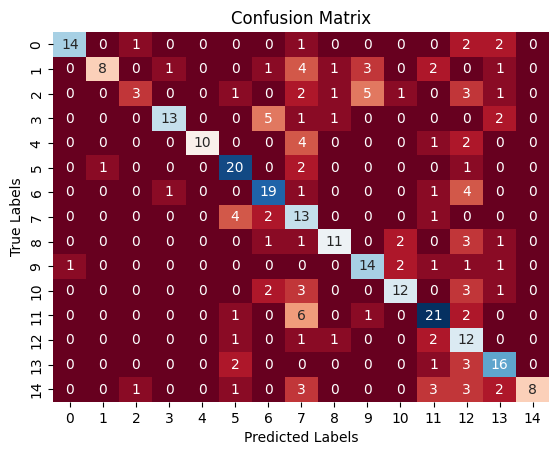

Test Accuracy is: 61.006%


In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')


image_data = '/content/drive/MyDrive/archive (4)/farm_insects'
pd.DataFrame(os.listdir(image_data), columns=['Files_Name'])

train_data_dir = image_data
batch_size = 32
target_size = (224, 224)
validation_split = 0.2


train = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)

class_names = train.class_names


plt.figure(figsize=(15, 20))
for images, labels in train.take(1):
    for i in range(8):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


base_model = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False


keras_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(15, activation=tf.nn.softmax)
])


tf.keras.utils.plot_model(keras_model,
                          to_file='model_inceptionv3.png',
                          show_shapes=True,
                          show_layer_names=True,
                          show_dtype=True,
                          dpi=80)


keras_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])


early_stopping = EarlyStopping(patience=5, restore_best_weights=True)


hist = keras_model.fit(train, epochs=30, validation_data=validation, callbacks=[early_stopping])


hist_df = pd.DataFrame(hist.history)
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(hist_df['loss'], label='Train Loss')
plt.plot(hist_df['val_loss'], label='Validation Loss')
plt.title('Train Loss & Validation Loss', fontsize=20)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_df['accuracy'], label='Train Accuracy')
plt.plot(hist_df['val_accuracy'], label='Validation Accuracy')
plt.title('Train Accuracy & Validation Accuracy', fontsize=20)
plt.legend()
plt.show()


X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

predictions = keras_model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))


df = pd.DataFrame()
df['Actual'], df['Prediction'] = y_val, y_pred


plt.figure(figsize=(25, 25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")
plt.show()


ax = plt.subplot()
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cbar=False, cmap='RdBu')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.show()


acc = accuracy_score(y_val, y_pred)
print("Test Accuracy is: {0:.3f}%".format(acc * 100))
